In [1]:
# Imports and util functions
import pandas as pd
from collections import Counter
from dataclasses import dataclass
from matplotlib import pyplot as plt
from pprint import pprint

%matplotlib auto

def fmt_answers(ans_1, ans_2="Something"):
    return f"Part One Answer: {ans_1}\nPart Two Answer: {ans_2}"

def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches


Using matplotlib backend: module://matplotlib_inline.backend_inline


Part One Answer: 2430334
Part Two Answer: 28786472


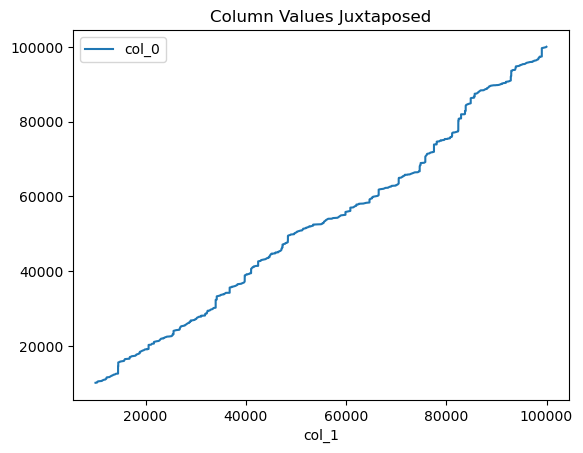

<Axes: title={'center': 'Column Differences Over Index Position'}>

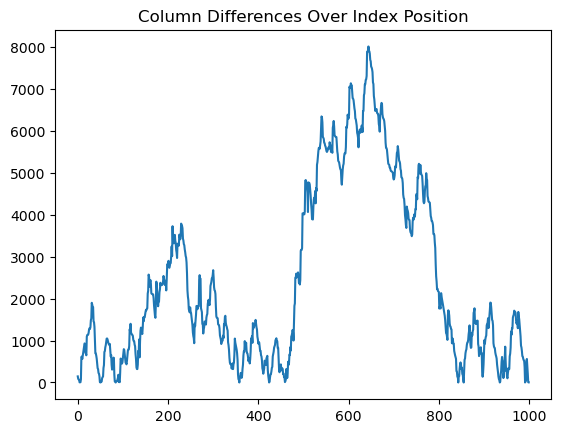

In [2]:
""" 
DAY 1 
Part 1 - Sort the two lists in ascending order. Calculate the absolute distance between each element in the two lists and sum that. Complexity: O(n)
Part 2 - Multiply each value in the left list by the number of times it occurs in the right list and sum that. Complexity: O(n)
"""
def read(file):
    with open(file) as ifp:
        d = [i.strip().split() for i in ifp]
        d1 = sorted(int(i[0]) for i in d)
        d2 = sorted(int(i[1]) for i in d)
    return d1, d2


def pt_1(file):
    d1, d2 = read(file)
    diffs = 0
    for i, j in zip(d1, d2):
        diffs += abs(i-j)
    return diffs
    

def pt_2(file):
    d1, d2 = read(file)
    sims = 0
    counts = Counter(d2)
    for i in d1:
        sims += i * counts.get(i, 0)
    return sims


print(fmt_answers(pt_1("data/day1-1.txt"), pt_2("data/day1-1.txt")))

### VIZ ###
df = pd.DataFrame()
for idx, col in enumerate(read("data/day1-1.txt")):
    df[f"col_{idx}"] = col
df.plot(kind="line", x="col_1", y="col_0", title="Column Values Juxtaposed")
plt.show()
plt.close()

diffs = abs(df["col_0"] - df["col_1"])
diffs.plot(title="Column Differences Over Index Position")

In [3]:
""" 
DAY 2 
Part 1 - Determine whether each sequence of integers in the input matches the "safe" conditions. Complexity: O(n)
Part 2 - Same exercise, but add logic to determine if dropping an element from the input matches the "safe" conditions. 
    Complexity: O(n^2) in the worst case. Here we only check results that are not already "safe" and move on after the first dropped element that satisfies the "safe" conditions, saving a few cycles.
"""
def read(file):
    with open(file) as ifp:
        d = [
            i.strip().split()
            for i in ifp
        ]
        dd = []
        for l in d:
            dd.append([int(x) for x in l])
    return dd
    
data = read("data/day2.txt")


def is_safe(ints):
    # Unspoken condition - no dups
    unique = len(set(ints)) == len(ints)
    if not unique:
        return False

    # Check for all ascending, descending
    sorted_ints = sorted(ints)
    all_inc = sorted_ints == ints
    all_dec = sorted_ints[::-1] == ints
    if not any([all_inc, all_dec]):
        return False

    # No diffs > 3
    for idx, i in enumerate(ints[:-1]):
        if abs(ints[idx] - ints[idx+1]) > 3:
            return False

    return True

def day2(data=data):
    # part one
    res = []
    for l in data:
        res.append([is_safe(l), l])
    pt_1 = sum(i[0] for i in res)

    # part 2
    for r_idx, l in enumerate(res):
        safe, ints = l
        if not safe:
            for idx, i in enumerate(ints):
                new_ints = [v for v_idx, v in enumerate(ints) if v_idx != idx]
                safe = is_safe(new_ints)
                if safe:
                    res[r_idx][0] = safe
                    continue

    pt_2 = sum(i[0] for i in res)

    return pt_1, pt_2

print(fmt_answers(*day2()))

Part One Answer: 218
Part Two Answer: 290


In [4]:
"""
DAY 3
Part 1 - Find sequences of 'mul(ints)' in an array of strings. Multiply those values and return the sum over all of them. Complexity: O(n)
    This seems like they want you to use regex, but regex is slow so I've implemented a solution in linear time.
Part 2 - Additional 'do' and 'don't' logic determines whether the command should be carried out or not. Complexity: O(n)
"""
def read(file):
    with open(file) as ifp:
        data = [i.strip() for i in ifp]
    return data
    
day3_data = read("data/day3.txt")


def get_cmds(l, prune=False):
    """TODO: Change the long if/elif/else block into a dict"""
    cmds = []
    cmd = " "
    for c in l:
        if cmd == " " and c == "m":
            cmd += c
        elif cmd == " m" and c == "u":
            cmd += c
        elif cmd == " mu" and c == "l":
            cmd += c
        elif cmd == " mul" and c == "(":
            cmd += c
        elif cmd == " mul(" and c.isdigit():
            cmd += c
        elif cmd[-1].isdigit() and "," not in cmd and any([c.isdigit(), c == ","]):
            cmd += c
        elif cmd[-1] == "," and any([c.isdigit(), c == ")"]):
            cmd += c
        elif cmd[-1].isdigit() and "," in cmd and c.isdigit():
            cmd += c
        elif cmd[-1].isdigit() and c == ")" and "," in cmd:
            cmd += c
            cmds.append(cmd[1:])
            cmd = " "
        else:
            cmd = " "

    if prune:
        do_pos = list(find_all(l, "do("))
        dont_pos = list(find_all(l, "don't("))
    
        negated_ranges = []
        for dont in dont_pos:
            for do in do_pos:
                if do > dont:
                    negated_ranges.append([dont, do])
                    break
        
        to_del = []
        for cmd in cmds:
            cmd_pos = l.find(cmd)
            for (start, end) in negated_ranges:
                if start < cmd_pos < end:
                    # print((start, end), cmd_pos)
                    # print(cmd, l[:cmd_pos+len(cmd)])
                    to_del.append(cmd)
                    break
        for cmd in to_del:
            cmds.remove(cmd)

    return cmds


def do_mult(cmd):
    """Convert `mul` commands into a product of integers"""
    try:
        a, b = cmd.split(",")
    except:
        print(cmd)
    a = "".join(c for c in a if c.isdigit())
    b = "".join(c for c in b if c.isdigit())
    return int(a) * int(b)


def day3(data):
    cmds = []
    total = 0
    for l in data:
        cmds.extend(get_cmds(l, prune=False))

    for c in cmds:
        total += do_mult(c)
    pt1 = total

    cmds = []
    total = 0
    all_data = "".join(data)
    cmds.extend(get_cmds(all_data, prune=True))
    for c in cmds:
        total += do_mult(c)
    pt2 = total

    return pt1, pt2

print(fmt_answers(*day3(day3_data)))


Part One Answer: 188192787
Part Two Answer: 113965544


In [5]:
"""
DAY 4
Part 1 - Find all instances of 'XMAS' and 'SAMX' in a two dimensional array of letters. 
I convert the rows, columns, and diagonals (left and right) into 1-d strings and use pattern matching to identify 'XMAS' and 'SAMX'. Complexity: O(n)

Part 2 - Find all instances of 'MAS' in an x-configuration, as in 

M.S
.A.
M.S

I start with the second row and for each letter that is 'A', check the upper-left, upper-right, lower-left, and lower-right Points relative to it, until the penultimate row is exhausted. 
This was much easier than Part 1 due to the X always having the same number of letters. 
Complexity: O(n)
"""

def read(file):
    with open(file) as ifp:
        d = [i.strip() for i in ifp]
    return d
        

def matches(l):
    left = len(list(find_all(l, "XMAS")))
    right = len(list(find_all(l, "SAMX")))
    return left + right
    

# Part 1
def day4(data = read("data/day4.txt")):
    """
    Identify columns, rows, and diagonals. Convert those to strings and pass to `matches()`.
    Right-diagonals cannot exceed min(room_down, room_left) in length.
    Left-diagonals cannot exceed min(room_down, room_right) in length.
    """
    matches_found = 0
    points = []
    cols = []
    rows = []
    r_diags = []
    l_diags = []

    # Columns - not required, but deals with variable row length
    # You could rewrite this section to rely on a square input, but where is the fun in that
    for col_idx in range(len(data[0])):
        room_down = len(data)
        col = ""
        for _ in range(room_down):
            col += data[_][col_idx]
        cols.append(col)

    # Rows
    for row_idx in range(len(data)):
        room_right = len(data[row_idx])
        row = ""
        for _ in range(room_right):
            row += data[row_idx][_]
        rows.append(row)

    # Right diagonals beginning in the lower-left quadrant and proceeding up
    # [↘]  ↘  ↘
    # [↘] [↘]  ↘
    # [↘] [↘] [↘]
    for row_idx in reversed(range(len(data))):
        room_right = len(data[row_idx])
        room_down = len(data) - row_idx
        r_diag_len = min(room_right, room_down)
        r_diag = ""
        
        for _ in range(r_diag_len):
            r_diag += data[row_idx + _][_]
        r_diags.append(r_diag)

    
    # Right diagonals beginning in the upper-left quadrant and proceeding right
    # Skip point(0,0) as it is the final element of the preceeding calculation.
    # ↘  [↘] [↘]
    # ↘   ↘  [↘]
    # ↘   ↘   ↘
    for col_idx in range(1, len(data[0])):
        room_right = len(data[0][col_idx:])
        room_down = len(data)
        r_diag_len = min(room_right, room_down)
        r_diag = ""
        
        for _ in range(r_diag_len):
            r_diag += data[_][col_idx + _]
        r_diags.append(r_diag)

    # Left diagonals beginning in the upper-left quadrant and proceeding right
    # [↙] [↙] [↙]
    # [↙] [↙]  ↙
    # [↙]  ↙   ↙
    for col_idx in range(len(data[0])):
        room_left = len(data[0][:col_idx])
        room_down = len(data)
        l_diag_len = min(room_left, room_down)
        x_pos = col_idx
        y_pos = 0
        l_diag = data[y_pos][x_pos]
        
        for _ in range(l_diag_len):
            x_pos -= 1
            y_pos += 1
            l_diag += data[y_pos][x_pos]
        l_diags.append(l_diag)

    # Left diagonals beginning in the upper-right quadrant and proceeding down 
    # Skip point(0,-1) as it is the final element of the preceeding calculation.
    #  ↙   ↙   ↙
    #  ↙   ↙  [↙]
    #  ↙  [↙] [↙]
    for row_idx in range(1, len(data)):
        room_left = len(data[row_idx])
        room_down = len(data) - row_idx
        l_diag_len = min(room_left, room_down) - 1
        x_pos = len(data[row_idx]) - 1
        y_pos = row_idx
        l_diag = data[y_pos][x_pos]
        
        for _ in range(l_diag_len):
            x_pos -= 1
            y_pos += 1
            l_diag += data[y_pos][x_pos]
        l_diags.append(l_diag)
        
    diags = l_diags + r_diags
    for c in cols:
        matches_found += matches(c)
    for r in rows:
        matches_found += matches(r)
    for diag in diags:
        matches_found += matches(diag)
    return matches_found


# Part 2
@dataclass
class Point:
    x: int
    y: int


def up_left(p):
    return Point(p.x - 1, p.y - 1)


def up_right(p):
    return Point(p.x + 1, p.y - 1)


def down_left(p):
    return Point(p.x - 1, p.y + 1)


def down_right(p):
    return Point(p.x + 1, p.y + 1)


def checker(ul, ur, dl, dr):
    return all([
        ul + dr == "MS" or ul + dr == "SM",
        ur + dl == "MS" or ur + dl == "SM"
    ])


def day4_pt_2(data = read("data/day4.txt")):
    """Check each 'A' for the required upper-right, upper-left, lower-right, and lower-left relatives"""
    
    def get_letter(p):
        """Encapsulation so we only have to read data once"""
        return data[p.y][p.x]
    
    c = 0
    for y_idx in range(1, len(data) - 1):
        for x_idx in range(1, len(data[y_idx]) - 1):
            if data[y_idx][x_idx] == "A":
                mid = Point(x_idx, y_idx)
                ul = get_letter(up_left(mid))
                ur = get_letter(up_right(mid))
                dl = get_letter(down_left(mid))
                dr = get_letter(down_right(mid))
                c += checker(ul, ur, dl, dr)
    return c


day4_pt1 = day4()
day4_pt2 = day4_pt_2()
print(fmt_answers(day4_pt1, day4_pt2))

Part One Answer: 2462
Part Two Answer: 1877
